In [36]:

import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
from torch import Tensor
from delaunay_rasterization.internal.alphablend_tiled_slang import render_alpha_blend_tiles_slang_raw
from scipy.spatial import Voronoi, Delaunay
from torch import nn
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
import tinycudann as tcnn
from utils.contraction import contract_mean_std
from utils import topo_utils
from tqdm import tqdm
import numpy as np
# from dtet import DelaunayTriangulation
# from dtet.build.dtet import DelaunayTriangulation
from gDel3D.build.gdel3d import Del
from scipy.spatial import KDTree
from utils import cam_util

K = 20

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def focal2fov(focal, pixels):
    return 2*math.atan(pixels/(2*focal))

def get_slang_projection_matrix(znear, zfar, fy, fx, height, width, device):
    tanHalfFovX = width/(2*fx)
    tanHalfFovY = height/(2*fy)

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    z_sign = 1.0

    P = torch.tensor([
       [2.0 * znear / (right - left),     0.0,                          (right + left) / (right - left), 0.0 ],
       [0.0,                              2.0 * znear / (top - bottom), (top + bottom) / (top - bottom), 0.0 ],
       [0.0,                              0.0,                          z_sign * zfar / (zfar - znear),  -(zfar * znear) / (zfar - znear) ],
       [0.0,                              0.0,                          z_sign,                          0.0 ]
    ], device=device)

    return P

def common_camera_properties_from_gsplat(viewmats, Ks, height, width):
  """ Fetches all the Camera properties from the inria defined object"""
  zfar = 100.0
  znear = 0.01
  
  world_view_transform = viewmats
  fx = Ks[0,0]
  fy = Ks[1,1]
  projection_matrix = get_slang_projection_matrix(znear, zfar, fy, fx, height, width, Ks.device)
  fovx = focal2fov(fx, width)
  fovy = focal2fov(fy, height)

  cam_pos = viewmats.inverse()[:, 3]

  return world_view_transform, projection_matrix, cam_pos, fovy, fovx

/home/dronelab/delaunay_rasterization


In [37]:
train_cameras, test_cameras, scene_info = loader.load_dataset(
    "/optane/nerf_datasets/360/bicycle", "images_8", data_device="cuda", eval=True)

Reading camera 194/194
Loaded Train Cameras: 169
Loaded Test Cameras: 25


In [38]:

torch.manual_seed(2)
N = scene_info.point_cloud.points.shape[0]
vertices = torch.as_tensor(scene_info.point_cloud.points)[:N]
minv = vertices.min(dim=0, keepdim=True).values
maxv = vertices.max(dim=0, keepdim=True).values
repeats = 3
vertices = vertices.reshape(-1, 1, 3).expand(-1, repeats, 3)
vertices = vertices + torch.randn(*vertices.shape) * 5e-1
N = 50000
vertices = torch.cat([
  vertices.reshape(-1, 3),
  torch.rand((N, 3)) * (maxv - minv) + minv
], dim=0)
vertices = nn.Parameter(vertices.cuda())

device = torch.device('cuda')
encoding = tcnn.Encoding(3, dict(
    otype="HashGrid",
    n_levels=16,
    n_features_per_level=2,
    log2_hashmap_size=14,
    base_resolution=16,
    per_level_scale=2
))
network = tcnn.Network(encoding.n_output_dims, 4, dict(
    # otype="CutlassMLP",
    otype="FullyFusedMLP",
    activation="ReLU",
    output_activation="None",
    n_neurons=64,
    n_hidden_layers=2,
))
net = torch.nn.Sequential(
    encoding, network
).to(device)


def safe_exp(x):
  return x.clip(max=5).exp()

def safe_trig_helper(x, fn, t=100 * torch.pi):
  """Helper function used by safe_cos/safe_sin: mods x before sin()/cos()."""
  return fn(torch.nan_to_num(torch.where(torch.abs(x) < t, x, x % t)))


def safe_cos(x):
  """jnp.cos() on a TPU may NaN out for large values."""
  return safe_trig_helper(x, torch.cos)


def safe_sin(x):
  """jnp.sin() on a TPU may NaN out for large values."""
  return safe_trig_helper(x, torch.sin)

def rgbs_fn(xyz):
  cxyz, _ = contract_mean_std(xyz, torch.ones_like(xyz[..., 0]))
  rgbs_raw = net((cxyz/2 + 1)/2).float()
  rgbs = torch.cat([torch.sigmoid(3*rgbs_raw[:, :3]), safe_exp(rgbs_raw[:, 3:]-3)], dim=1)
  return rgbs


In [39]:
camera = train_cameras[0]
print(camera.projection_matrix)

tensor([[ 1.8801,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.8164,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0001,  1.0000],
        [ 0.0000,  0.0000, -0.0100,  0.0000]], device='cuda:0')


: 

  0%|          | 0/2000 [00:00<?, ?it/s, PSNR=9.58 Mean: 0.0]

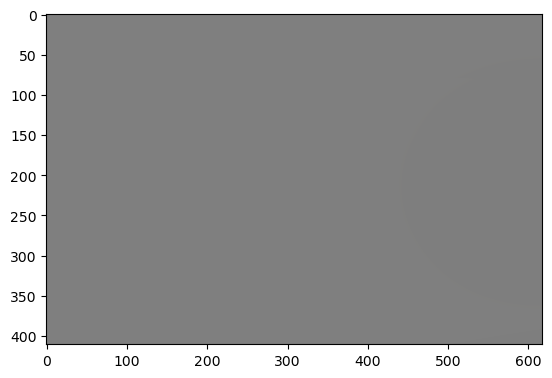

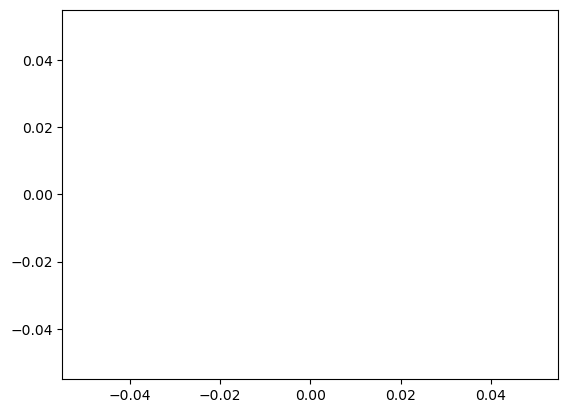

"<source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAABAdtZGF0AAACfwYF//973EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzA5NSBiYWVlNDAwIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD00IHRocmVhZHM9MTMgbG9va2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByYz1jcXAgbWJ0cmVlPTAgcXA9MjAgaXBfcmF0aW89MS40MCBwYl9yYXRpbz0xLjMwIGFxPTAAgAAAAXhliIQA//7zm+//8sB/ss/z6vRP4NscFRTiRutEs5UQA31JDt2E70981yVAaK08kQuZQttWhy3vjwwpSLcgpbZWGhedbCsUV8o6Kk6isdLYVHXWx/XE/L6IACalh2mu285WJgSUyzdwWpflP3L99O//Q3xXpClcm3UZB+V7cK3jWtjhJ2x1KRHmeK0hKEpwiKcZdvvOzx7OxfJ/125JiA7ST6JB97lxc6DJ+VDJw678A3Mwh7VeagXfDnIPb7ZfKa3wSAlptn0HSMcp6kir8AAeMMv+ua1uNCDFF+YBInyx5rwpxAnpcTagARy/K6XSW9zr+HAKwA4ypYXN6oWifbGocmAA3nw/nBEBPI5xyTt7bAqbXINbX6jV+ZZXGmQSFGOV3KCRW245WpuXXY3YzqTjk5/foXm+/e0/kd/DU0G0+7kaeHQxiwxDvMd43db3osUUVAnsJECJ19SLGhxoOoF8uL2+ec9sSsfCTj0hKyU5I3rCL8pW7UBTAAADCG1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAAAARAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAIydHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAAAARAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJqAAABmwAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAAAEQAAAAAAAQAAAAABqm1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAPAAAAAEAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAAVVtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAEVc3RibAAAALFzdHNkAAAAAAAAAAEAAAChYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJqAZsASAAAAEgAAAAAAAAAARVMYXZjNjAuMzEuMTAyIGxpYngyNjQAAAAAAAAAAAAAABj//wAAADdhdmNDAfQAH//hABpn9AAfkZsoE4a880IAAAMAAgAAAwDwHjBjLAEABmjr4bESEf/4+AAAAAAUYnRydAAAAAAAB34gAAd+IAAAABhzdHRzAAAAAAAAAAEAAAABAAABAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAAQAAAAEAAAAUc3RzegAAAAAAAAP/AAAAAQAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY2MC4xNi4xMDA="" type=""video/mp4""/> This browser does not support the video tag."


 25%|██▌       | 500/2000 [02:24<06:45,  3.70it/s, PSNR=17.94 Mean: 15.901701461653975]

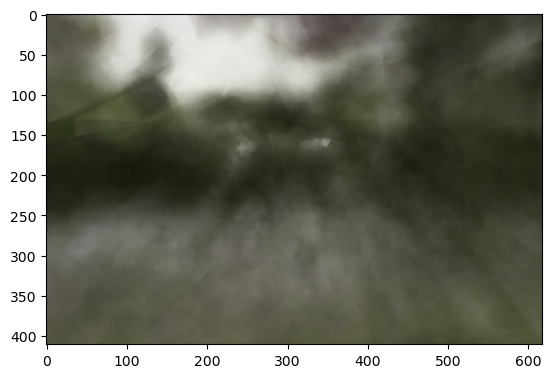

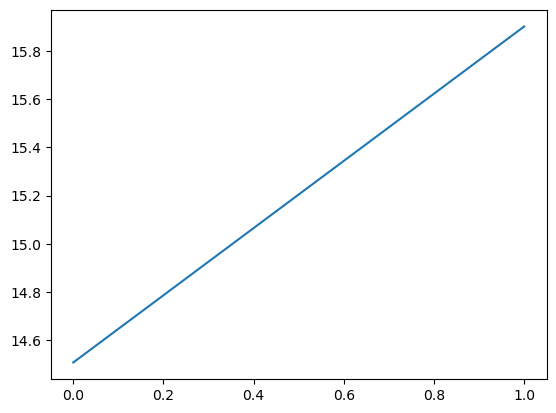

 36%|███▌      | 712/2000 [03:26<06:46,  3.17it/s, PSNR=16.89 Mean: 16.95593981715252] 

In [40]:
def render(camera, indices, vertices, cell_values=None):
    fy = fov2focal(camera.fovy, camera.image_height)
    fx = fov2focal(camera.fovx, camera.image_width)
    K = torch.tensor([
    [fx, 0, camera.image_width/2],
    [0, fy, camera.image_height/2],
    [0, 0, 1],
    ]).to(camera.world_view_transform.device)

    # world_view_transform, projection_matrix, cam_pos, fovy, fovx = common_camera_properties_from_gsplat(
    #     camera.world_view_transform.T, K, camera.image_height, camera.image_width)
    cam_pos = camera.world_view_transform.T.inverse()[:, 3]

    render_pkg = render_alpha_blend_tiles_slang_raw(indices, vertices, rgbs_fn,
                                                    camera.world_view_transform.T, K, cam_pos,
                                                    camera.fovy, camera.fovx, camera.image_height,
                                                    camera.image_width, cell_values=cell_values,
                                                    tile_size=tile_size)
    return render_pkg

optim = torch.optim.Adam([
    {"params": net.parameters(), "lr": 5e-3},
    {"params": [vertices], "lr": 1e-3},
])
tile_size = 8
images = []

# v = DelaunayTriangulation()
# v.init_from_points(vertices.detach().cpu().numpy())
# indices_np = v.get_cells()
v = Del(vertices.shape[0])
indices_np = v.compute(vertices.detach().cpu()).numpy()

# v = Delaunay(vertices.detach().cpu().numpy())
# indices_np = v.simplices

indices_np = indices_np[np.lexsort(indices_np.T)].astype(np.int32)
indices = torch.as_tensor(indices_np).cuda()

old_vertices = vertices.detach().cpu().numpy()
render_pkg = render(camera, indices, vertices)
last_circumcenters = render_pkg['circumcenters']
num_violations = []
num_tets = []
psnrs = [[]]
inds = []

# progress_bar = tqdm(range(4*len(train_cameras)+2))
progress_bar = tqdm(range(2000))
for i in progress_bar:
    optim.zero_grad()


    # ind = random.randint(0, len(train_cameras)-1)
    if len(inds) == 0:
        inds = list(range(len(train_cameras)))
        random.shuffle(inds)
        psnrs.append([])
    ind = inds.pop()
    # ind = 1
    camera = train_cameras[ind]
    target = camera.original_image.cuda()

    st = time.time()
    render_pkg = render(camera, indices, vertices)
    # print(1/(time.time()-st))
    image = render_pkg['render']
    loss = ((target - image)**2).mean()
    psnr = 20 * math.log10(1.0 / math.sqrt(loss.detach().cpu().item()))
    psnrs[-1].append(psnr)
    
    disp_ind = max(len(psnrs)-2, 0)
    avg_psnr = sum(psnrs[disp_ind]) / max(len(psnrs[disp_ind]), 1)
    progress_bar.set_postfix({"PSNR": f"{psnr:.02f} Mean: {avg_psnr}"})

    ind = 1
    camera = train_cameras[ind]
    render_pkg = render(camera, indices, vertices)
    image = render_pkg['render']
    image = image.permute(1, 2, 0)
    image = image.detach().cpu().numpy()
    images.append(image)
    loss.backward()
    optim.step()

    # st = time.time()
    if i % 1 == 0:
        # v = Delaunay(vertices.detach().cpu().numpy())
        # indices_np = v.simplices

        # vertices_np = vertices.detach().cpu().numpy()
        # torch.cuda.synchronize()
        # # v = DelaunayTriangulation()
        # # v.init_from_points(vertices_np)
        # v.update_points(vertices_np)
        # indices_np = v.get_cells()

        v = Del(vertices.shape[0])
        indices_np = v.compute(vertices.detach().cpu()).numpy()


        # indices_np = indices_np[np.lexsort(indices_np.T)]
        indices = torch.as_tensor(indices_np.astype(np.int32)).cuda()
        old_vertices = vertices.detach().cpu().numpy()

    # new_vertices = vertices.detach().cpu().numpy()
    # indices_np, _ = topo_utils.update_tetrahedralization(old_vertices, new_vertices, indices_np)
    # indices = torch.as_tensor(indices_np).cuda()

    if i % 500 == 0:
        plt.imshow(image)
        plt.show()
        avged_psnrs = [sum(v)/len(v) for v in psnrs if len(v) == len(train_cameras)]
        plt.plot(range(len(avged_psnrs)), avged_psnrs)
        plt.show()
        mediapy.show_video(images)
avged_psnrs = [sum(v)/len(v) for v in psnrs if len(v) == len(train_cameras)]
plt.plot(range(len(avged_psnrs)), avged_psnrs)
plt.show()
mediapy.show_video(images)
plt.plot(range(len(num_violations)), num_violations)
plt.plot(range(len(num_tets)), num_tets)
plt.show()

In [ ]:
cameras = cam_util.generate_cam_path(train_cameras, 400)
print(cameras[0].world_view_transform)

cuda:0
tensor([[-0.9441,  0.0046,  0.3295,  0.0000],
        [ 0.1089,  0.9481,  0.2987,  0.0000],
        [-0.3110,  0.3179, -0.8957,  0.0000],
        [ 0.4491, -0.3689,  4.0266,  1.0000]], device='cuda:0')


In [ ]:
eimages = []
for camera in cameras:
    render_pkg = render(camera, indices, vertices)
    image = render_pkg['render']
    image = image.permute(1, 2, 0)
    image = image.detach().cpu().numpy()
    eimages.append(image)

mediapy.show_video(eimages)